MNIST data contains images of hand written digits 0 to 9; each image size is (28 x 28)

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
# torchvision library is part of the PyTorch project, consists of popular datasets, model architectures, and common image transformations for computer vision.

In [2]:
# If GPU is available operations will be performed on GPU otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Downloading the data and converting to tensor

In [3]:
# root="/path" defines where data should go; in this case it will go in default directory(for default we also could just use "" without writing root=)
# train=True means to train the data
# download=True to download the data; once downloaded it won't download again
# transform=transforms.Compose([transforms.ToTensor()]) converting data into tensor
train_data = datasets.MNIST(root="MNIST_DATA", train=True, download=True, 
                       transform=transforms.Compose([transforms.ToTensor()])) 

test_data = datasets.MNIST(root="MNIST_DATA", train=False, download=False, 
                      transform=transforms.Compose([transforms.ToTensor()]))

#### Creating batches of data to pass in training loop

In [4]:
# All datasets are subclasses of torch.utils.data.Dataset(represents a Python iterable over a dataset) i.e, they have __getitem__ and __len__ methods implemented. Hence, they can all be 
# passed to a torch.utils.data.DataLoader which can load multiple samples parallelly using torch.multiprocessing workers. 
# If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0.
# DataLoader: Takes any Dataset and creates an iterator which returns batches of data
# batch_size represents the size of samples which we are going to feed in the model; an arbitrary number
# shuffle=True so data can be trained with different items
trainset = torch.utils.data.DataLoader(dataset=train_data, batch_size=10, shuffle=True)

testset = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

#### To see how first batch of data looks like

tensor(4)
tensor(6)
tensor(3)
tensor(3)
tensor(8)
tensor(2)


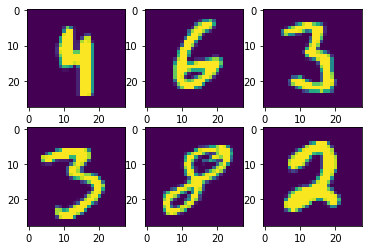

In [5]:
import matplotlib.pyplot as plt
# Method 1:

# To check single element

# for data in trainset:
#     #print(data)
#     break

# x, y = data[0][0], data[1][0]
# print(y)
# import matplotlib.pyplot as plt
# plt.imshow(x[0])
# plt.show()


# To check multiple elements
for data in trainset:
    for i in range(6):
        x, y = data[0][i], data[1][i]
        print(y)
        plt.subplot(2,3,i+1)
        plt.imshow(x[0])
    break
plt.show()
# for data in trainset:
#     for i in range(6):
#         x, y = data
#         plt.subplot(2,3, i+1)
#         plt.imshow(x[i][0])
#         print(y[i])
#     break
# plt.show()

# Method 2:

# first_batch = iter(trainset)
# images, labels = first_batch.next()
# print(images.shape, labels.shape)

# for i in range(10):
#     plt.subplot(2,5,i+1)
#     plt.imshow(images[i][0])
# plt.show()

#### Look on data 

In [6]:
# Having a look on data how it has been distributed; if not properly distributed equally then have to balance it otherwise the weights are going to stuck on a point 
# and loss can't be decreased from a certain value

total_elements = 0
digits_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, }

for data in trainset:
    x, y = data
    for i in y:
        digits_dict[int(i)] += 1
        total_elements += 1
        
print(total_elements)
print(digits_dict)

for i in digits_dict:
    print(f"key = {i}, count = {digits_dict[i]}, percent = {round(100*digits_dict[i]/total_elements,2)}%")

60000
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
key = 0, count = 5923, percent = 9.87%
key = 1, count = 6742, percent = 11.24%
key = 2, count = 5958, percent = 9.93%
key = 3, count = 6131, percent = 10.22%
key = 4, count = 5842, percent = 9.74%
key = 5, count = 5421, percent = 9.04%
key = 6, count = 5918, percent = 9.86%
key = 7, count = 6265, percent = 10.44%
key = 8, count = 5851, percent = 9.75%
key = 9, count = 5949, percent = 9.91%


#### Building the Neural Network

In [7]:
# functional: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, 
# as well as non-stateful versions of layers such as convolutional and linear layers

import torch.nn as nn
import torch.nn.functional as F

# Module: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). 
# It knows what Parameter (s) it contains and can zero all their gradients, loop 
class Nnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)     # input= 784 => 28*28; hidden layer=64 (arbitrary number) as output
        self.fc2 = nn.Linear(64, 64)      # fc1 output was 64 so fc2 input is 64; again second hidden layer=64 (arbitrary number)
        self.fc3 = nn.Linear(64, 64)      # fc2 output was 64 so fc3 input is 64; again second hidden layer=64 (arbitrary number)
        self.fc4 = nn.Linear(64, 10)      # fc3 output was 64 so fc4 input is 64; output is 10 because data has 0-9 digits
        
    def forward(self, x):                 # feed forward method
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
net = Nnet().to(device)

#### Training the model

In [8]:
# torch.optim: Contains optimizers such as SGD, which update the weights of Parameter during the backward step
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCH = 3         # going to make 3 whole passes through entire dataset
one_epoch_steps = len(trainset)

for epoch in range(EPOCH):
    for idx, data in enumerate(trainset):
        x, y = data
        x = x.view(-1,28*28).to(device)
        y = y.to(device)
        pred_out = net(x)   # -1 is used to represent whatever batch size is
        loss = F.nll_loss(pred_out, y)
        # optim.zero_grad() resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch
        net.zero_grad()
        loss.backward()
        optimizer.step()
        if (idx)%1000==999:
            print(f'epoch={epoch+1}/{EPOCH}, step={idx+1}/{one_epoch_steps}, loss={loss.item():.15f}')

epoch=1/3, step=1000/6000, loss=0.154947131872177
epoch=1/3, step=2000/6000, loss=0.069240890443325
epoch=1/3, step=3000/6000, loss=0.101538620889187
epoch=1/3, step=4000/6000, loss=0.122869953513145
epoch=1/3, step=5000/6000, loss=0.058587957173586
epoch=1/3, step=6000/6000, loss=0.728203237056732
epoch=2/3, step=1000/6000, loss=0.218361169099808
epoch=2/3, step=2000/6000, loss=0.078737646341324
epoch=2/3, step=3000/6000, loss=0.055690623819828
epoch=2/3, step=4000/6000, loss=0.262235730886459
epoch=2/3, step=5000/6000, loss=0.043340459465981
epoch=2/3, step=6000/6000, loss=0.225408434867859
epoch=3/3, step=1000/6000, loss=0.010230599902570
epoch=3/3, step=2000/6000, loss=0.025454849004745
epoch=3/3, step=3000/6000, loss=0.049931813031435
epoch=3/3, step=4000/6000, loss=0.477973788976669
epoch=3/3, step=5000/6000, loss=0.009507542476058
epoch=3/3, step=6000/6000, loss=0.007160594221205


#### Testing the accuracy

In [9]:
n_correct = 0
total_samples = 0

with torch.no_grad():
    for data in testset:
        x, y = data
        x = x.view(-1,28*28).to(device)
        y = y.to(device)
        output = net(x)
        for idx, i in enumerate(output):
            # Returns the indices of the maximum value of all elements in the input tensor
            # torch.argmax() returns the second value of torch.max()
            # value, index = torch.max(output, 1)
            if torch.argmax(i) == y[idx]:
                n_correct += 1
            total_samples += 1
accuracy = 100 * n_correct / total_samples
print(f'Accuracy = {accuracy}')

Accuracy = 96.9


#### Verifying the value with images

tensor(7)
tensor(8)
tensor(9)
tensor(0)
tensor(1)
tensor(2)


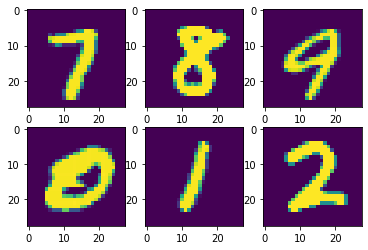

In [10]:
import matplotlib.pyplot as plt

for i in range(6):
    print(torch.argmax(net(x[i].view(-1,784))[0]))
    plt.subplot(2,3,i+1)
    plt.imshow(x[i].view(28,28))
plt.show()

For official documentation click **[here](https://pytorch.org/tutorials/beginner/nn_tutorial.html)**

## TensorBoard

Using tensorboard displaying data on images tab, model on graph tab and accuray & loss on scalar tab; code used for tensorborad is uncommented

Install TensorBoard running command in cmd (pip install tensorboard) and start it from cmd like jupyter notebook (tensorboard --logdir=/path/directory_name), these utilities let you log PyTorch models and metrics into a directory for visualization within the TensorBoard UI. Scalars, images, histograms, graphs, and embedding visualizations are all supported for PyTorch models and tensors as well as Caffe2 nets and blobs

In [11]:
# Uncomment all the code before running

# import torch
# import torchvision
# from torchvision import datasets, transforms
# import matplotlib.pyplot as plt

## The SummaryWriter class is the main entry to log data for consumption and visualization by TensorBoard
from torch.utils.tensorboard import SummaryWriter

## tensorboard extension needs to be loaded(only once) before running it through jupyter notebook(alternative way of cmd)
%load_ext tensorboard   

## Refresh the tensorboard from the given button to have the changes appear
## launching tensor board in jupyter notebook alternative way of cmd
%tensorboard --logdir=runs


## writer will output to ./runs/ directory by default, this is log directory
# writer = SummaryWriter("runs/mnist_logs")

# train_data = datasets.MNIST(root="MNIST_DATA", train=True, download=True, 
#                        transform=transforms.Compose([transforms.ToTensor()])) 

# test_data = datasets.MNIST(root="MNIST_DATA", train=False, download=False, 
#                       transform=transforms.Compose([transforms.ToTensor()]))


# trainset = torch.utils.data.DataLoader(dataset=train_data, batch_size=100, shuffle=True)

# testset = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)


## for data in trainset:
##     x, y = data
##     break
## another way
data = iter(trainset)
x, y = data.next()

## making a grid with all images to display
img_grid = torchvision.utils.make_grid(x)

## adding the grid to as an image to tensorboard
writer.add_image('MNIST Images', img_grid)

## clearing the writer
writer.close()

    
# import torch.nn as nn
# import torch.nn.functional as F

# class Nnet(nn.Module):
    
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(784, 64)     
#         self.fc2 = nn.Linear(64, 64)      
#         self.fc3 = nn.Linear(64, 64)      
#         self.fc4 = nn.Linear(64, 10)      
        
#     def forward(self, x):                 
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return F.log_softmax(x, dim=1)
    
# model = Nnet()

# import torch.optim as optim

# optimizer = optim.Adam(model.parameters(), lr=0.001)


## adding graph to see the models with input, linear layer, activation function, output  flow chart
writer.add_graph(model, x.view(-1,28*28))
writer.close()

# EPOCH = 3

catch_loss = 0
catch_accuracy = 0

# for epoch in range(EPOCH):
#     for idx, data in enumerate(trainset):
#         x, y = data
#         x = x.view(-1,28*28)
        
#         pred_out = model(x)  
#         loss = F.nll_loss(pred_out, y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
        ## capture the loss
        catch_loss += loss.item() 
        
        ## measuring the accuracy 
        catch_accuracy += (torch.argmax(pred_out, 1) == y).sum().item()
        
#         if (idx)%100==99:
#             print(f'epoch={epoch+1}/{EPOCH}, step={idx+1}/{len(trainset)}, loss={loss.item():.15f}')
            
            ## adding scalar to see the loss and accuracy on tensorboard
            writer.add_scalar('training loss', catch_loss/100, epoch * len(trainset) + idx)
            writer.add_scalar('training accuracy', catch_accuracy/100, epoch * len(trainset) + idx)
            
            ## reseting the variable to catch the loss for another batch
            catch_loss = 0
            catch_accuracy = 0
            
            ## clearing the writer
            writer.close()

Reusing TensorBoard on port 6006 (pid 7564), started 5:26:44 ago. (Use '!kill 7564' to kill it.)

epoch=1/3, step=100/600, loss=0.547341048717499
epoch=1/3, step=200/600, loss=0.439677387475967
epoch=1/3, step=300/600, loss=0.301797777414322
epoch=1/3, step=400/600, loss=0.230129033327103
epoch=1/3, step=500/600, loss=0.304620951414108
epoch=1/3, step=600/600, loss=0.260904073715210
epoch=2/3, step=100/600, loss=0.204097837209702
epoch=2/3, step=200/600, loss=0.111001320183277
epoch=2/3, step=300/600, loss=0.146681696176529
epoch=2/3, step=400/600, loss=0.154352992773056
epoch=2/3, step=500/600, loss=0.380173087120056
epoch=2/3, step=600/600, loss=0.164586007595062
epoch=3/3, step=100/600, loss=0.106613472104073
epoch=3/3, step=200/600, loss=0.218865469098091
epoch=3/3, step=300/600, loss=0.191051274538040
epoch=3/3, step=400/600, loss=0.073826529085636
epoch=3/3, step=500/600, loss=0.257843017578125
epoch=3/3, step=600/600, loss=0.098212480545044


![TensorBoard Scalar](png/scalar.png)

![TensorBoard Images](png/data_batch.png "Images")

![TensorBoard Graph](png/model.png "Graph")

torch.utils.tensorboard **[documentation](https://pytorch.org/docs/stable/tensorboard.html)**